In [2]:
import torch
import torch.nn as nn
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

<>:46: SyntaxWarning: invalid escape sequence '\o'
<>:46: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_8515/4010872162.py:46: SyntaxWarning: invalid escape sequence '\o'
  plt.plot(interval, x1_values, label="Predadores ($\omega$)", color="orange", linewidth=2)


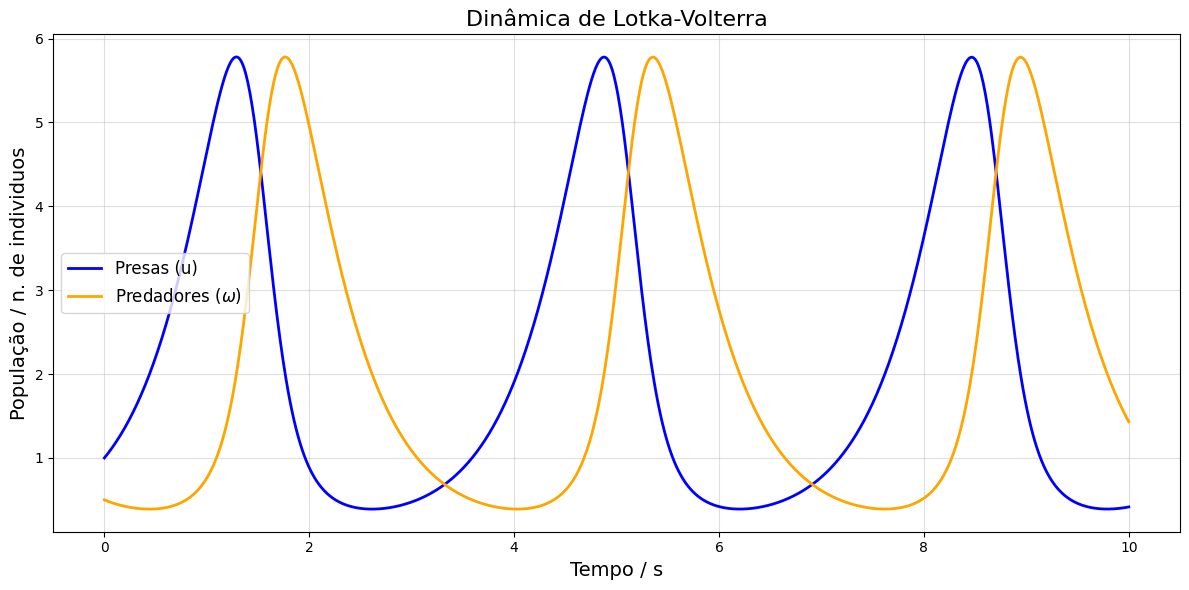

In [85]:
# Intervalo de tempo refinado
interval = np.linspace(0, 10, 1000)  # 1000 pontos no tempo
x0_values = []
x1_values = []

# Definição do modelo Lotka-Volterra
x = ca.MX.sym('x', 2)
alpha = 2.0
beta = 1.0
delta = 1.0
gamma = 2.0

rhs = ca.vertcat(alpha * x[0] - beta * x[0] * x[1],
                 delta * x[0] * x[1] - gamma * x[1])

ode = {'x': x, 'ode': rhs}

# Criar integrador com passo de tempo
dt = interval[1] - interval[0]
F = ca.integrator('F', 'cvodes', ode, {'tf': dt})

# Condições iniciais
x0 = [1.0, 0.5]  # u(0) = 1.0, v(0) = 0.5
x0_values.append(x0[0])
x1_values.append(x0[1])

# Iterar sobre o intervalo
for t in range(len(interval) - 1):
    sol = F(x0=x0)  # Solução para o próximo passo
    xf_values = np.array(sol["xf"]).flatten()
    x0_values.append(xf_values[0])  # Adiciona u(t)
    x1_values.append(xf_values[1])  # Adiciona v(t)
    x0 = xf_values  # Atualiza condições iniciais para o próximo passo

# Transformar em arrays NumPy
x0_values = np.array(x0_values)
x1_values = np.array(x1_values)

# Plotar os resultados
plt.figure(figsize=(12, 6))

# População de presas
plt.plot(interval, x0_values, label="Presas (u)", color="blue", linewidth=2)

# População de predadores
plt.plot(interval, x1_values, label="Predadores ($\omega$)", color="orange", linewidth=2)

# Configurações do gráfico
plt.title("Dinâmica de Lotka-Volterra", fontsize=16)
plt.xlabel("Tempo / s", fontsize=14)
plt.ylabel("População / n. de individuos", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()
# Gerar dados (usando o código anterior)
np.savez("lotka_volterra_data.npz", t=interval, u=x0_values, v=x1_values)


In [94]:
import torch
import torch.nn as nn
import random
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy

# Classe PINN com pruning aplicado corretamente em todas as camadas
class PINN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=200, output_dim=2, num_layers=4, custom_layers=None):
        super(PINN, self).__init__()
        if custom_layers is not None:
            self.layers = nn.Sequential(*custom_layers)
        else:
            self.hidden_dim = hidden_dim
            layers = []
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.LeakyReLU())

            for _ in range(num_layers - 2):
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                layers.append(nn.LeakyReLU())

            layers.append(nn.Linear(hidden_dim, output_dim))
            self.layers = nn.Sequential(*layers)

    def forward(self, t):
        return self.layers(t)

    def _calculate_dynamic_threshold(self, weights):
        return torch.max(torch.abs(weights)) * 0.08

    def get_active_neurons_masks(self):
        masks = []
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                threshold = self._calculate_dynamic_threshold(layer.weight.data)
                masks.append((torch.abs(layer.weight.data) > threshold).any(dim=1))
            else:
                masks.append(None)
        return masks
    
    def prune_neurons(self):
            """Retorna máscaras de neurônios ativos por camada"""
            masks = []
            for layer in self.layers:
                if isinstance(layer, nn.Linear):
                    threshold = self._calculate_dynamic_threshold(layer.weight.data)
                    mask = torch.abs(layer.weight.data) > threshold
                    layer.weight.data *= mask.float()
                    masks.append(mask.any(dim=1))
                    neurons_to_prune = torch.all(mask == 0, dim=1)
                    if layer.bias is not None:
                        layer.bias.data[neurons_to_prune] = 0
                      # Máscara para linhas (neurônios)
                else:
                    masks.append(None)
            return masks

    def create_pruned_model(self):
        masks = self.get_active_neurons_masks()
        new_layers = []
        prev_mask = None

        for i, layer in enumerate(self.layers):
            if isinstance(layer, nn.Linear):
                current_mask = masks[i]
                active_neurons = torch.sum(current_mask).item()

                if prev_mask is None:  # Primeira camada
                    new_layer = nn.Linear(layer.in_features, active_neurons)
                    new_layer.weight.data = layer.weight.data[current_mask, :]
                    new_layer.bias.data = layer.bias.data[current_mask]
                else:  # Camadas seguintes
                    in_features = torch.sum(prev_mask).item()
                    new_layer = nn.Linear(in_features, active_neurons)
                    new_layer.weight.data = layer.weight.data[current_mask, :][:, prev_mask]
                    new_layer.bias.data = layer.bias.data[current_mask]

                new_layers.append(new_layer)
                new_layers.append(nn.LeakyReLU())
                prev_mask = current_mask

        # Remove a última ativação se a última camada for linear
        if len(new_layers) > 0 and isinstance(new_layers[-1], nn.LeakyReLU):
            new_layers.pop()

        return PINN(custom_layers=new_layers)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def get_neuron_counts(self):
        """Retorna o número de neurônios em cada camada oculta"""
        counts = []
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                counts.append(layer.out_features)
        return counts

    def print_pruning_report(self):
        """Exibe relatório detalhado de neurônios ativos"""
        active_counts, total_active = self.count_active_neurons()
        original_counts = self.get_neuron_counts()
        
        print("\nRelatório de Pruning:")
        print("Camada | Neurônios Originais | Neurônios Ativos | % Mantidos")
        print("-----------------------------------------------------------")
        for i, (orig, active) in enumerate(zip(original_counts, active_counts)):
            if i == len(original_counts)-1:
                print(f"Saída  | {orig:>18} | {active:>15} | {active/orig:.1%}")
            else:
                print(f"{i+1:>5}  | {orig:>18} | {active:>15} | {active/orig:.1%}")
        print(f"\nTotal de neurônios ativos: {total_active}/{sum(original_counts)} ({total_active/sum(original_counts):.1%})")
    
    def count_active_neurons(self):
        """Conta neurônios ativos usando threshold dinâmico"""
        active_counts = []
        total_active = 0

        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                weights_abs = torch.abs(layer.weight.data)
                threshold = self._calculate_dynamic_threshold(layer.weight.data)
                active_neurons = (weights_abs > threshold).any(dim=1)  # Verifica por linha
                count = torch.sum(active_neurons).item()
                active_counts.append(count)
                total_active += count

        return active_counts, total_active

# Função de perda
def loss_pinn(model, t_train, u_train, v_train, alpha, beta, delta, gamma):
    t_train.requires_grad = True
    uv_pred = model(t_train)
    u_pred, v_pred = uv_pred[:, 0], uv_pred[:, 1]

    data_loss = torch.mean((u_pred - u_train) ** 2 + (v_pred - v_train) ** 2)

    u_t = torch.autograd.grad(u_pred, t_train, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    v_t = torch.autograd.grad(v_pred, t_train, grad_outputs=torch.ones_like(v_pred), create_graph=True)[0]
    eq1 = u_t - (alpha * u_pred - beta * u_pred * v_pred)
    eq2 = v_t - (delta * u_pred * v_pred - gamma * v_pred)
    physics_loss = torch.mean(eq1 ** 2 + eq2 ** 2)

    return data_loss + 1E-3 * physics_loss

# Função de Simulated Annealing com pruning atualizado
def simulated_annealing_with_pruning(
    model, t_train, u_train, v_train, alpha, beta, delta, gamma,
    T_init=1.0, T_min=0.001, eta=0.90, MLL=200, prune_interval=500
):
    T = T_init
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_loss = float('inf')
    best_model = copy.deepcopy(model.state_dict())
    loss_history = []
    pruning_history = []
    global_step = 0

    with tqdm(total=int((T_init - T_min) / (T_init * (1 - eta))), desc="Simulated Annealing") as pbar_outer:
        while T > T_min:
            with tqdm(total=MLL, desc=f"Temperatura: {T:.4f}", leave=False) as pbar_inner:
                for step in range(MLL):
                    loss = loss_pinn(model, t_train, u_train, v_train, alpha, beta, delta, gamma)
                    loss_history.append(loss.item())

                    temp_model = copy.deepcopy(model)
                    temp_model.load_state_dict(model.state_dict())

                    with torch.no_grad():
                        for param in temp_model.parameters():
                            param.add_(T * torch.randn_like(param))

                    new_loss = loss_pinn(temp_model, t_train, u_train, v_train, alpha, beta, delta, gamma)

                    if new_loss < loss or math.exp((loss - new_loss) / T) > random.random():
                        model.load_state_dict(temp_model.state_dict())
                        loss = new_loss

                    if loss < best_loss:
                        best_loss = loss
                        best_model = copy.deepcopy(model.state_dict())

                    # Aplica pruning e coleta estatísticas
                    if step % prune_interval == 0:
                        masks = model.prune_neurons()
                        active_counts, total_active = model.count_active_neurons()
                        pruning_history.append({
                            'step': global_step,
                            'active_neurons': active_counts,
                            'total_active': total_active
                        })

                        # Aplica máscaras nos gradientes
                        for i, layer in enumerate(model.layers):
                            if isinstance(layer, nn.Linear) and masks[i] is not None and layer.weight.grad is not None:
                                mask = masks[i]
                                mask_expanded = mask.view(-1, 1).expand_as(layer.weight.grad)
                                layer.weight.grad.data *= mask_expanded.float()

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    global_step += 1
                    pbar_inner.set_postfix(
                        loss=loss.item(),
                        active_neuronios=f"{pruning_history[-1]['total_active'] if pruning_history else 'N/A'}"
                    )
                    pbar_inner.update(1)

            T *= eta
            pbar_outer.update(1)

    model.load_state_dict(best_model)
    model.print_pruning_report()
    plot_pruning_evolution(pruning_history, model.get_neuron_counts())
    return model, loss_history, pruning_history

def plot_pruning_evolution(pruning_history, original_counts):
    plt.figure(figsize=(12, 6))
    
    # Plota neurônios totais ativos
    steps = [p['step'] for p in pruning_history]
    total_active = [p['total_active'] for p in pruning_history]
    
    plt.plot(steps, total_active, label="Neurônios Ativos", linewidth=2)
    plt.axhline(y=sum(original_counts), color='r', linestyle='--', label="Total Original")
    
    plt.xlabel("Iteração")
    plt.ylabel("Neurônios Ativos")
    plt.title("Evolução dos Neurônios Ativos durante o Pruning")
    plt.legend()
    plt.grid(True)
    plt.show()



# Função para plotar a loss
def plot_loss(loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label="Loss")
    plt.xlabel("Iteração")
    plt.ylabel("Loss")
    plt.title("Evolução da Loss durante o Simulated Annealing")
    plt.legend()
    plt.grid(True)
    plt.show()

Simulated Annealing: 66it [06:17,  5.72s/it]                      



Relatório de Pruning:
Camada | Neurônios Originais | Neurônios Ativos | % Mantidos
-----------------------------------------------------------
    1  |                200 |             104 | 52.0%
    2  |                200 |             149 | 74.5%
    3  |                200 |             173 | 86.5%
Saída  |                  2 |               2 | 100.0%

Total de neurônios ativos: 428/602 (71.1%)


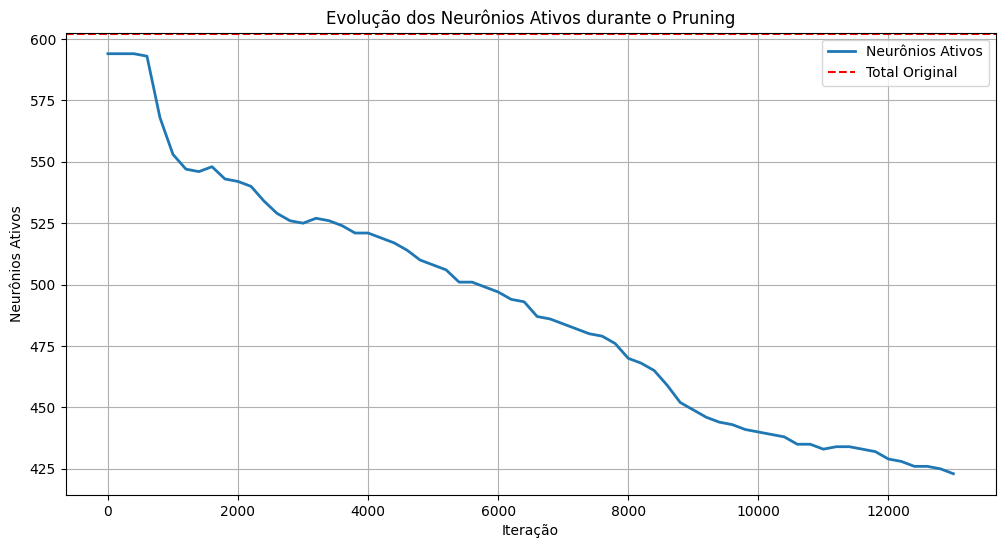

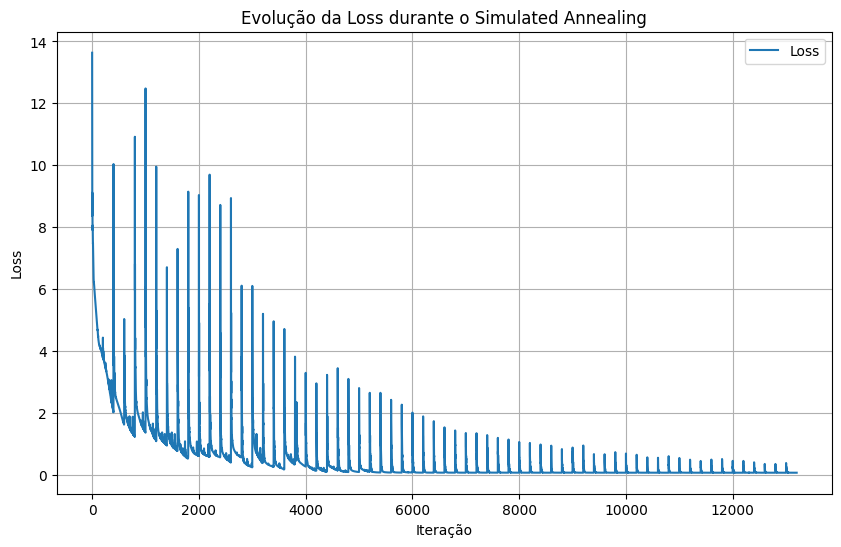


Modelo final:
PINN(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)

Relatório de Pruning:
Camada | Neurônios Originais | Neurônios Ativos | % Mantidos
-----------------------------------------------------------
    1  |                200 |             104 | 52.0%
    2  |                200 |             149 | 74.5%
    3  |                200 |             173 | 86.5%
Saída  |                  2 |               2 | 100.0%

Total de neurônios ativos: 428/602 (71.1%)


In [95]:
# Carregar os dados
data = np.load("lotka_volterra_data.npz")
t_data = torch.tensor(data["t"], dtype=torch.float32).unsqueeze(1)  # Domínio temporal
u_data = torch.tensor(data["u"], dtype=torch.float32)  # Valores de u(t)
v_data = torch.tensor(data["v"], dtype=torch.float32)  # Valores de v(t)


model = PINN()

# Executar Simulated Annealing com pruning
model, loss_history, pruning_history = simulated_annealing_with_pruning(
    model, t_data, u_data, v_data, alpha, beta, delta, gamma
)

# Plotar a loss
plot_loss(loss_history)
# Ver detalhes da arquitetura final
print("\nModelo final:")
print(model)

# Ver estatísticas detalhadas
model.print_pruning_report()



In [96]:
# Criar modelo reduzido
pruned_model = model.create_pruned_model()

# Comparar tamanhos
print(f"Parâmetros original: {model.count_parameters()}")
print(f"Parâmetros pruned: {pruned_model.count_parameters()}")
print("\nModelo pruned:")
print(pruned_model)

Parâmetros original: 81202
Parâmetros pruned: 42151

Modelo pruned:
PINN(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=104, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=104, out_features=149, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=149, out_features=173, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=173, out_features=2, bias=True)
  )
)


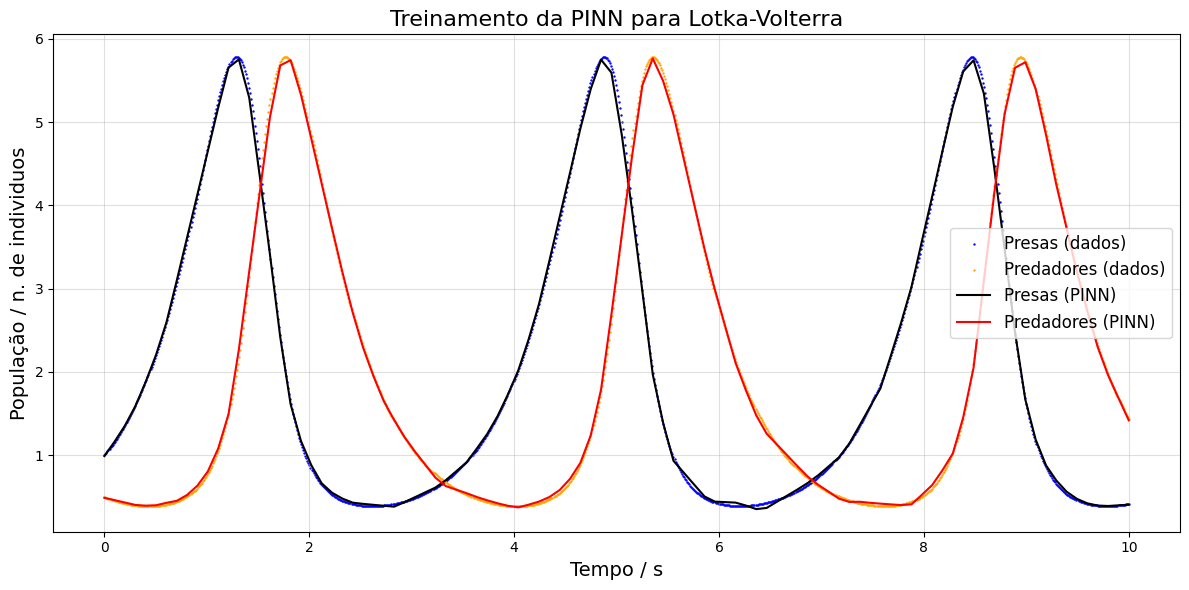

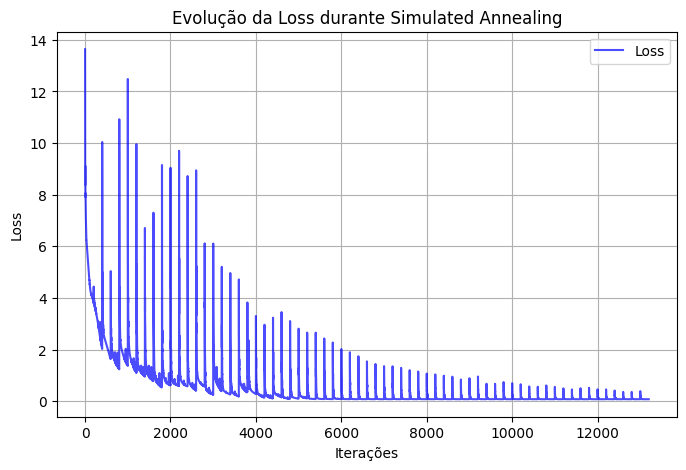

In [97]:
# Criar 100 pontos uniformemente espaçados para avaliação
t_test = torch.linspace(t_data.min(), t_data.max(), 100).unsqueeze(1)

# Fazer previsões com a PINN
uv_pred = pruned_model(t_test).detach().numpy()
u_pred, v_pred = uv_pred[:, 0], uv_pred[:, 1]

# Plotar os resultados
plt.figure(figsize=(12, 6))

# Dados reais (10 pontos de treinamento)
plt.scatter(data["t"], data["u"], label="Presas (dados)", color="blue", s=0.5, marker='o')
plt.scatter(data["t"], data["v"], label="Predadores (dados)", color="orange", s=0.5, marker='o')

# Previsões da PINN (100 pontos)
plt.plot(t_test.numpy(), u_pred, label="Presas (PINN)", color="black", linestyle="-")
plt.plot(t_test.numpy(), v_pred, label="Predadores (PINN)", color="red", linestyle="-")

plt.title("Treinamento da PINN para Lotka-Volterra", fontsize=16)
plt.xlabel("Tempo / s", fontsize=14)
plt.ylabel("População / n. de individuos", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss", color="blue", alpha=0.7)
plt.xlabel("Iterações")
plt.ylabel("Loss")
plt.title("Evolução da Loss durante Simulated Annealing")
plt.legend()
plt.grid(True)
plt.show()
